# Molecules

A molecular or chemical graph is a structural representation of molecule in which atoms are nodes and chemical bonds define the edges of the graph. 

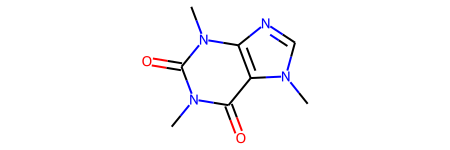

In [1]:
import rdkit.Chem as Chem
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")

A chemical structure can be depicted in 2D with chemiformatics software such as [`RDKit`](https://www.rdkit.org/) or [`OpenBabel`](https://www.rdkit.org/). Both have similar class definitions of molecules, atoms and bonds classes and provide a large scope of methods to work with molecular structures.

In `kgcnn.mol.base` a general interface `MolGraphInterface` is defined that should unify access to the chemical graph used for deep learning models. Both `RDKit` and `OpenBabel` can be used as backend (Note that `OpenBabel` must be installed manually since no complete pypi installation is yet available). 

In [2]:
from kgcnn.molecule.graph_rdkit import MolecularGraphRDKit
from kgcnn.molecule.graph_babel import MolecularGraphOpenBabel

Main operations to generate a molecular graph from e.g. smiles or mol-tables as well as generating and optimizting conformation or compute charges are methods of the interface and can be used with both `RDKit` or `OpenBabel` backend. Specific kwargs for those methods, however, are handed to the specific functions of the backend and therefore require knowledge about the paramters of the backend.

In [3]:
mg = MolecularGraphRDKit(make_directed=False)
mg.from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
mg.add_hs()
mg.make_conformer()
mg.optimize_conformer(force_field="mmff94")
mg.compute_partial_charges(method="gasteiger")

Note that the actual Mol-Class not privaate and accessible via `mol` .

In [4]:
str(mg.mol)

'<rdkit.Chem.rdchem.Mol object at 0x000001CE88AE51C0>'

Most importantly are methods to generate graph properties from the mol-object. In the example below are node and edge types or numbers, for the first 4 atoms or bonds, respectively:

In [5]:
mg.edge_indices[:4], mg.node_symbol[:4], mg.node_coordinates[:4], mg.edge_number[1][:4]  # Indices and bond order

(array([[ 0,  1],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16]], dtype=int64),
 ['C', 'N', 'C', 'N'],
 array([[ 3.26735076,  0.61278444, -0.2364124 ],
        [ 2.1264268 , -0.26661905, -0.26747634],
        [ 2.15131889, -1.61634095, -0.50052716],
        [ 0.94130742, -2.13852225, -0.46338622]]),
 [1, 1, 1, 1])

For attributed graphs a feature vector for atoms, bonds and the total graph has been found to improve GNNs. The functions of the interface `node_attributes` , `edge_attributes` and `graph_attributes` and take a list of strings (predifined) or functions for each attributes. Here are the list of attributes for `RDKit` by name:

In [6]:
MolecularGraphRDKit.atom_fun_dict.keys()

dict_keys(['NumBonds', 'AtomicNum', 'AtomMapNum', 'Idx', 'Degree', 'TotalDegree', 'Symbol', 'NumExplicitHs', 'NumImplicitHs', 'TotalNumHs', 'IsAromatic', 'Isotope', 'TotalValence', 'Mass', 'MassScaled', 'IsInRing', 'Hybridization', 'NoImplicit', 'ChiralTag', 'FormalCharge', 'ExplicitValence', 'ImplicitValence', 'NumRadicalElectrons', 'HasOwningMol', 'PDBResidueInfo', 'MonomerInfo', 'Smarts', 'CIPCode', 'CIPRank', 'ChiralityPossible', 'MolFileRLabel', 'GasteigerCharge', 'GasteigerHCharge', 'AtomFeatures', 'DescribeQuery', 'Rvdw', 'RvdwScaled', 'Rcovalent', 'RcovalentScaled'])

In [7]:
MolecularGraphRDKit.bond_fun_dict.keys()

dict_keys(['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo', 'Idx', 'BeginAtom', 'BeginAtomIdx', 'BondDir', 'BondTypeAsDouble', 'EndAtom', 'EndAtomIdx', 'Smarts', 'DescribeQuery'])

In [8]:
MolecularGraphRDKit.mol_fun_dict.keys()

dict_keys(['C', 'N', 'O', 'H', 'S', 'F', 'Cl', 'NumAtoms', 'AtomsIsInRing', 'AtomsIsAromatic', 'NumBonds', 'BondsIsConjugated', 'BondsIsAromatic', 'NumRotatableBonds', 'ExactMolWt', 'FpDensityMorgan3', 'FractionCSP3', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Ar_COO', 'fr_Al_OH', 'fr_Ar_OH', 'fr_C_O_noCOO', 'fr_NH2', 'fr_SH', 'fr_sulfide', 'fr_alkyl_halide'])

Then node attributes for the molecular graph can be generated from a list of attribute names.

In [9]:
mg.node_attributes(["NumBonds", "Mass", "Symbol", "IsInRing", "GasteigerCharge"], encoder={})[:4]

[[4, 12.011, 'C', False, '0.012958350519987684'],
 [3, 14.007, 'N', True, '-0.32786346609948208'],
 [3, 12.011, 'C', True, '0.097502273308341464'],
 [2, 14.007, 'N', True, '-0.21837692759548705']]

In order to have all features of a number data type an encoder can be added for each named feature:

In [10]:
from kgcnn.molecule.encoder import OneHotEncoder
mg.node_attributes(["NumBonds", "Mass", "Symbol", "IsInRing", "GasteigerCharge"], 
                   encoder={"Symbol": OneHotEncoder(["C", "O", "N", "H"], dtype="str"), "GasteigerCharge": float})[:4]

[[4, 12.011, 1, 0, 0, 0, 0, False, 0.012958350519987684],
 [3, 14.007, 0, 0, 1, 0, 0, True, -0.3278634660994821],
 [3, 12.011, 1, 0, 0, 0, 0, True, 0.09750227330834146],
 [2, 14.007, 0, 0, 1, 0, 0, True, -0.21837692759548705]]

If a feature is not in the list of named attributes, a function can be inserted in place. Note that the function should always return a single value or a list of values. Argument will be the bond, molecule or atom class of the backend, respectively.

In [11]:
def mol_feature(atom):
    # Note that you can also get the mol object with e.g.
    # mol = atom.GetOwningMol()
    return atom.GetAtomicNum()

mg.node_attributes([mol_feature], encoder={})[:4]

[[6], [7], [6], [7]]

The dataset `MoleculeNetDataset` uses the `MolGraphInterface` in `map_molecule_callbacks` , which specifies the used interface within `mol_interface_class` .

> **NOTE**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/docs/source